In [2]:
from load_data import  sim_arr

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split


# Split the data into train, test and validation sets
train_set, test_set = train_test_split(sim_arr, test_size=0.2, random_state=42)
train_set, valid_set = train_test_split(
    train_set, test_size=0.2, random_state=42)

print("Train set size: ", len(train_set),
      " Test set size: ", len(test_set),
      " Validation set size: ", len(valid_set))

Train set size:  1926  Test set size:  602  Validation set size:  482


In [4]:
# check gpu
import tensorflow as tf
import os


print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))

os.environ['XLA_FLAGS'] = './cuda_sdk_lib/'

2024-03-27 10:49:14.170845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 10:49:14.917161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2024-03-27 10:49:15.324528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 10:49:15.350073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 10:49:15.350341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
import optuna

from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError

# get input shape from the data
input_shape = train_set.shape[1:]
output_shape = (1, 1, 12)


def create_model(trial):
    # Hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 1, 4)

    filters = [trial.suggest_categorical(f'filters_{i}', [3, 6, 9, 12])
               for i in range(num_layers - 1)]
    filters.append(12)

    activation = [trial.suggest_categorical(
        f'activation_{i}', ['relu', 'selu', 'tanh', 'sigmoid']) for i in range(num_layers)]
    
    initializer = [trial.suggest_categorical(
        f'initializer_{i}', ['lecun_normal', 'he_normal', 'he_uniform', 'glorot_normal', 'glorot_uniform']) for i in range(num_layers)]

    kernel_sizes = [trial.suggest_int(
        f'kernel_size{i}', 2, 24) for i in range(num_layers)]

    poolsize = [[16],
                [4, 4],
                [2, 2, 4],
                [2, 2, 2, 2]]

    # Encoder
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer(input_shape=input_shape))
    for i in range(num_layers):
        encoder.add(MaxPool2D(poolsize[num_layers - 1][i]))
        encoder.add(Conv2D(
            filters[i],
            kernel_sizes[i],
            strides=1,
            activation=activation[i],
            padding='same',
            kernel_initializer=initializer[i]
        ))
    encoder.add(MaxPool2D(5))

    # Decoder
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer(input_shape=encoder.output_shape[1:]))
    for i in range(num_layers - 1, -1, -1):
        decoder.add(Conv2DTranspose(
            filters[i],
            kernel_sizes[i],
            strides=poolsize[num_layers - 1][i],
            activation=activation[i],
            padding='same',
            kernel_initializer=initializer[i]
        ))
    decoder.add(Conv2DTranspose(
        input_shape[-1],
        kernel_sizes[0],
        strides=5,
        activation=activation[0],
        padding='same',
        kernel_initializer=initializer[0]
    ))

    # Compile the model
    auto_encoder = Sequential([encoder, decoder], name="autoencoder")
    auto_encoder.compile(optimizer='adam', loss="MSE")

    return auto_encoder


def objective(trial):
    # Clear clutter from previous sessions
    tf.keras.backend.clear_session()

    # Create model
    model = create_model(trial)

    # Train the model
    history = model.fit(train_set, train_set, epochs=10, batch_size=16,
                        validation_data=(valid_set, valid_set), verbose=0)

    return history.history['val_loss'][-1]


# Perform hyperparameter optimization
study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.HyperbandPruner(),
                            study_name='autoencoder_1',
                            storage='sqlite:///test.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=10)


# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best value:", study.best_value)

[I 2024-03-27 12:18:52,442] Using an existing study with name 'autoencoder_1' instead of creating a new one.


2024-03-27 12:18:56.133327: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.97GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
[I 2024-03-27 12:20:21,461] Trial 184 finished with value: 0.00353803439065814 and parameters: {'num_layers': 4, 'filters_0': 12, 'filters_1': 12, 'filters_2': 6, 'activation_0': 'tanh', 'activation_1': 'tanh', 'activation_2': 'selu', 'activation_3': 'relu', 'initializer_0': 'he_uniform', 'initializer_1': 'glorot_normal', 'initializer_2': 'glorot_uniform', 'initializer_3': 'lecun_normal', 'kernel_size0': 23, 'kernel_size1': 20, 'kernel_size2': 17, 'kernel_size3': 22}. Best is trial 151 with value: 0.0026141214184463024.
[I 2024-03-27 12:21:46,975] Trial 185 finished with value: 0.003947152756154537 and parameters: {'num_layers': 4, 'filters_0': 12, 'filters_1': 12, 'filters_2': 6,

Best hyperparameters: {'num_layers': 4, 'filters_0': 12, 'filters_1': 12, 'filters_2': 6, 'activation_0': 'tanh', 'activation_1': 'tanh', 'activation_2': 'selu', 'activation_3': 'relu', 'initializer_0': 'he_normal', 'initializer_1': 'glorot_normal', 'initializer_2': 'glorot_normal', 'initializer_3': 'glorot_normal', 'kernel_size0': 23, 'kernel_size1': 12, 'kernel_size2': 21, 'kernel_size3': 20}
Best value: 0.0026141214184463024


In [11]:
# Train the model with the best hyperparameters
auto_encoder = create_model(study.best_trial)
history = auto_encoder.fit(train_set, train_set, epochs=10, batch_size=32,
                           validation_data=(valid_set, valid_set))

auto_encoder.evaluate(test_set, test_set)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.1932 - val_loss: 0.0799
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0769 - val_loss: 0.0513
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0496 - val_loss: 0.0322
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0350 - val_loss: 0.0256
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0260 - val_loss: 0.0174
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0182 - val_loss: 0.0123
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0120 - val_loss: 0.0122
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0107 - val_loss: 0.0078
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0063 - val_loss: 0.0053
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0063


0.006151093635708094

In [ ]:
# summarize the encoder and decoder architecture
auto_encoder.get_layer('encoder').summary()
auto_encoder.get_layer('decoder').summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 9)      │         1,737 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 9)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 12)       │         3,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 12)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,637 (22.02 KB)

 Trainable params: 5,637 (22.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_3              │ (None, 4, 4, 12)       │         5,196 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 9)      │         6,921 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 80, 80, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,848 (54.09 KB)

 Trainable params: 13,848 (54.09 KB)

 Non-trainable params: 0 (0.00 B)

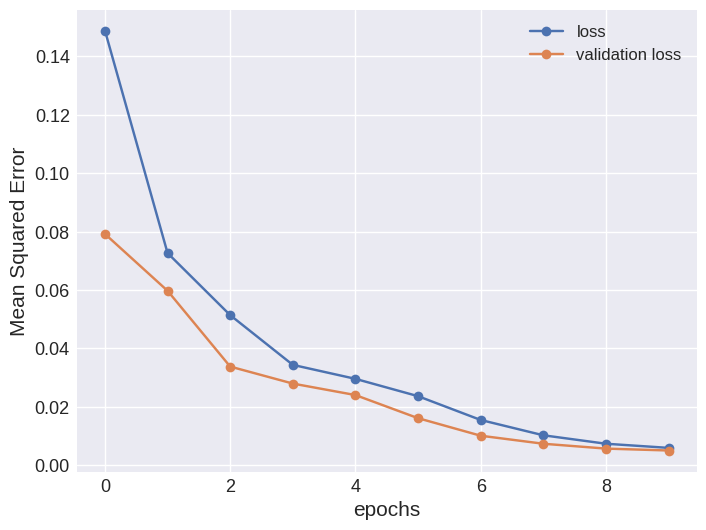

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], "-o", label="loss")
plt.plot(history.history["val_loss"], "-o", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.show()

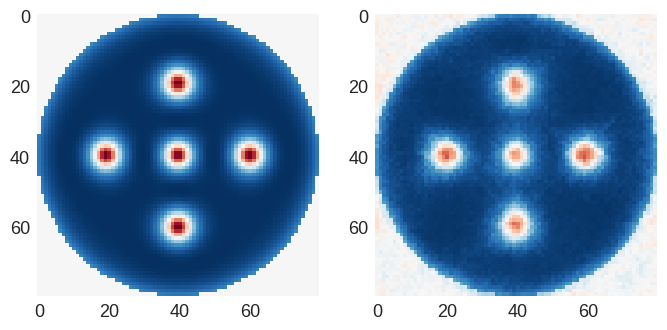

In [8]:
i = 25
in_sim = test_set[i: i + 1]
out_sim = auto_encoder(in_sim)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(in_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")
ax[1].imshow(out_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")

In [9]:
from tensorflow.keras.layers import Flatten as Flatten

feature_extractor = Sequential(
    [
        auto_encoder.get_layer("encoder"),
        Flatten(),
    ]
)

feat_shape = auto_encoder.get_layer("encoder").output_shape[-1]

feature_arr = feature_extractor.predict(sim_arr, verbose=2)

95/95 - 1s - 9ms/step


In [10]:
# Save the feature array
np.save("feature_arr.npy", feature_arr)

In [ ]:
autoencoder = create_model(study.best_trial)
dbscan = DBSCAN(eps=0.5, min_samples=10)

# custom loss function
def custom_loss(y_true, y_pred, cluster_labels):
    reconstruction_loss = MeanSquaredError()(y_true, y_pred)
    clustering_loss = silhouette_score(feature_arr, labels)
    return loss
    